In [1]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch


In [1]:
from IPython.core.debugger import set_trace

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score

style.use('ggplot')
%matplotlib notebook

In [2]:
# Load the data using Pandas

#file = "../data_v2/training/training_1.csv"
#file = "../data_v2/training/training_2.csv"
#file = "../data_v2/training/training_3.csv"
#file = "../data_v2/training/training_4.csv"
#file = "../data_v2/training/training_5.csv"
file = "../data_v2/training/training_100.csv"

df = pd.read_csv(file, parse_dates=['timestamp'], index_col=['timestamp'])
df.resample('3H')

In [3]:
# Inspect the data to detect missing values and consecitive periods
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20159 entries, 2020-08-14 02:00:00+02:00 to 2020-08-28 02:00:00+02:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   kpi_value      20159 non-null  float64
 1   request_count  20159 non-null  int64  
 2   anomaly_label  20159 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 630.0 KB


In [4]:
# Quick look at the data
df.head()

,kpi_value,request_count,anomaly_label
timestamp,,,
2020-08-14 02:00:00+02:00,0.998755,24908,0
2020-08-14 02:01:00+02:00,0.997683,25029,0
2020-08-14 02:02:00+02:00,0.998341,24115,0
2020-08-14 02:03:00+02:00,0.998211,24031,0
2020-08-14 02:04:00+02:00,0.998403,23790,0


<IPython.core.display.Javascript object>


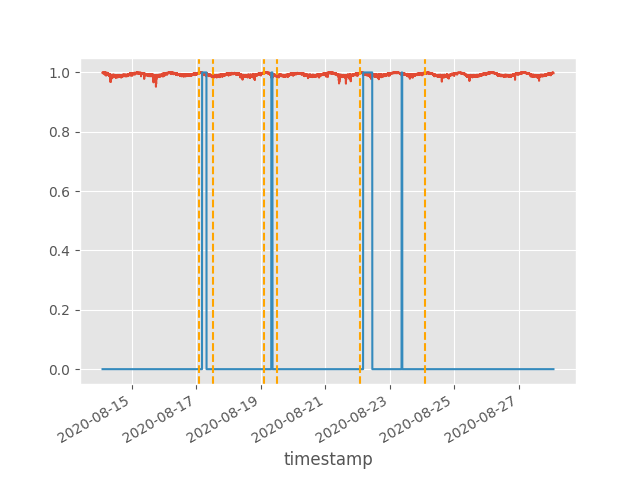

Start date is:  2020-08-14 02:00:00+02:00
End date is:  2020-08-28 02:00:00+02:00


In [5]:
# Plot the data to separate the anomaly periods from correct operation
plt.figure();
df['kpi_value'].plot()
df['anomaly_label'].plot()
#df['request_count'].plot()

# Manually select the split dates and plot them
splits = ['2020-08-17 00:00:00',
          '2020-08-17 10:00:00',
          '2020-08-19 00:00:00',
          '2020-08-19 10:00:00',
          '2020-08-22 00:00:00',
          '2020-08-24 00:00:00',]

for split in splits:
    plt.axvline(x=split, color='orange', linestyle='dashed')


print("Start date is: ", df.index.min())
print("End date is: ", df.index.max())

In [6]:
# Training intervals
train1 = df.loc[df.index <= splits[0]]

train2 = df.loc[(df.index > splits[1]) & (df.index <= splits[2])]

train3 = df.loc[(df.index > splits[3]) & (df.index <= splits[4])]

train4 = df.loc[df.index > splits[5]]


# Testing intervals
test1 = df.loc[(df.index > splits[0]) & (df.index <= splits[1])]

test2 = df.loc[(df.index > splits[2]) & (df.index <= splits[3])]

test3 = df.loc[(df.index > splits[4]) & (df.index <= splits[5])]

In [7]:
# Preprocessing: normalize the data in mean and variance
scaler = StandardScaler()
scaler = scaler.fit(pd.concat([train1, train2, train3, train4])[['kpi_value', 'request_count']])

train1[['kpi_value', 'request_count']] = scaler.transform(train1[['kpi_value', 'request_count']])
train2[['kpi_value', 'request_count']] = scaler.transform(train2[['kpi_value', 'request_count']])
train3[['kpi_value', 'request_count']] = scaler.transform(train3[['kpi_value', 'request_count']])
train4[['kpi_value', 'request_count']] = scaler.transform(train4[['kpi_value', 'request_count']])

trainSeqs = [train1, train2, train3, train4]

# Avoid leakage of information between train and test dataset

test1[['kpi_value', 'request_count']] = scaler.transform(test1[['kpi_value', 'request_count']])
test2[['kpi_value', 'request_count']] = scaler.transform(test2[['kpi_value', 'request_count']])
test3[['kpi_value', 'request_count']] = scaler.transform(test3[['kpi_value', 'request_count']])

testSeqs = [test1, test2, test3]

/home/solozabal/anaconda3/envs/huawei/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/solozabal/anaconda3/envs/huawei/lib/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/home/solozabal/anaconda3/envs/huawei/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [8]:
# Compute the train to test ratio

learn_ratio = pd.concat(trainSeqs).shape[0] / df.shape[0]
print("Learn dataset ratio: " "{:.2f}".format(learn_ratio))

test_ratio = pd.concat(testSeqs).shape[0] / df.shape[0]
print("Learn dataset ratio: " "{:.2f}".format(test_ratio))

Learn dataset ratio: 0.80
Learn dataset ratio: 0.20


In [9]:
TIME_STEPS = 32

# Create the sequences of size TIME_STEPS to feed the sequential model
def to_sequences(x, y, TIME_STEPS=1):
    x_values = []
    y_values = []

    for i in range(len(x)-TIME_STEPS):
        x_values.append(x.iloc[i:(i+TIME_STEPS)].values)
        y_values.append(y.iloc[i+1:(i+TIME_STEPS+1)])
        
    return np.array(x_values), np.array(y_values)

# Stack the sequences obtained in each period to create a single training tensor
trainX = np.array([])
trainY = np.array([])
testX = np.array([])
testY = np.array([])

for train in trainSeqs:
    x, y = to_sequences(train[['kpi_value', 'request_count']], train[['kpi_value']], TIME_STEPS)
    trainX = np.vstack([trainX, x]) if trainX.size else x
    trainY = np.vstack([trainY, y]) if trainY.size else y
    
for test in testSeqs:
    x, y = to_sequences(test[['kpi_value', 'request_count']], test[['kpi_value']], TIME_STEPS)
    testX = np.vstack([testX, x]) if testX.size else x
    testY = np.vstack([testY, y]) if testY.size else y

In [10]:
trainY.shape

(15951, 32, 1)

model = keras.Sequential(
    [
        layers.Input(shape=(trainX.shape[1], trainX.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

In [11]:
#Build the keras model
model = Sequential()
model.add(layers.LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(layers.Dropout(rate=0.2))

model.add(layers.RepeatVector(trainX.shape[1]))

model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(rate=0.2))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67072     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 32, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 32, 1)             129       
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
__________________________________________________

In [12]:
# Fit model
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ])

Epoch 1/50
449/449 [==============================] - 10s 19ms/step - loss: 0.2971 - val_loss: 0.1965
Epoch 2/50
449/449 [==============================] - 8s 18ms/step - loss: 0.2399 - val_loss: 0.1818
Epoch 3/50
449/449 [==============================] - 8s 17ms/step - loss: 0.2281 - val_loss: 0.1762
Epoch 4/50
449/449 [==============================] - 8s 17ms/step - loss: 0.2233 - val_loss: 0.1702
Epoch 5/50
449/449 [==============================] - 8s 17ms/step - loss: 0.2208 - val_loss: 0.1681
Epoch 6/50
449/449 [==============================] - 8s 17ms/step - loss: 0.2155 - val_loss: 0.1662
Epoch 7/50
449/449 [==============================] - 8s 17ms/step - loss: 0.2156 - val_loss: 0.1629
Epoch 8/50
449/449 [==============================] - 8s 17ms/step - loss: 0.2153 - val_loss: 0.1605
Epoch 9/50
449/449 [==============================] - 8s 17ms/step - loss: 0.2120 - val_loss: 0.1666
Epoch 10/50
449/449 [==============================] - 8s 17ms/step - loss: 0.2111 - val_l

<IPython.core.display.Javascript object>


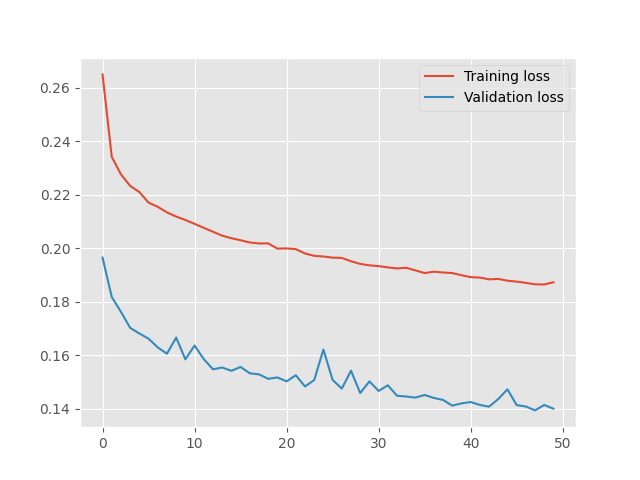

In [13]:
# Plot the training and validation loss 
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

<IPython.core.display.Javascript object>


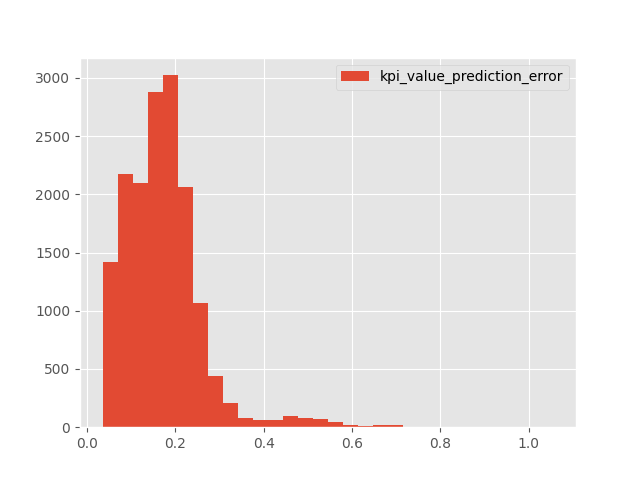

In [14]:
# Plot a histogram of the reconstruction error in the training dataset to decide a threshold

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainY), axis=1)
plt.figure();
plt.hist(trainMAE, bins=30);
plt.legend(['kpi_value_prediction_error'])
threshold_trainMAE = 0.3  #or Define 90% value of max as threshold.

<IPython.core.display.Javascript object>


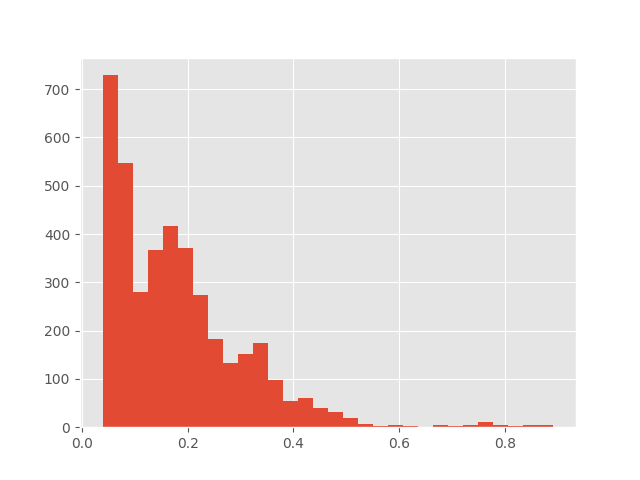

In [15]:
# Histogram of the testing MAE
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testY), axis=1)
plt.figure();
plt.hist(testMAE, bins=30);

In [16]:
# Detect anomaly if the reconstruction loss for a sample is greater than the threshold

anomaly_df = pd.concat([seq[TIME_STEPS:] for seq in testSeqs])
anomaly_df['testMAE'] = testMAE
anomaly_df['threshold_trainMAE'] = threshold_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['threshold_trainMAE']


<IPython.core.display.Javascript object>


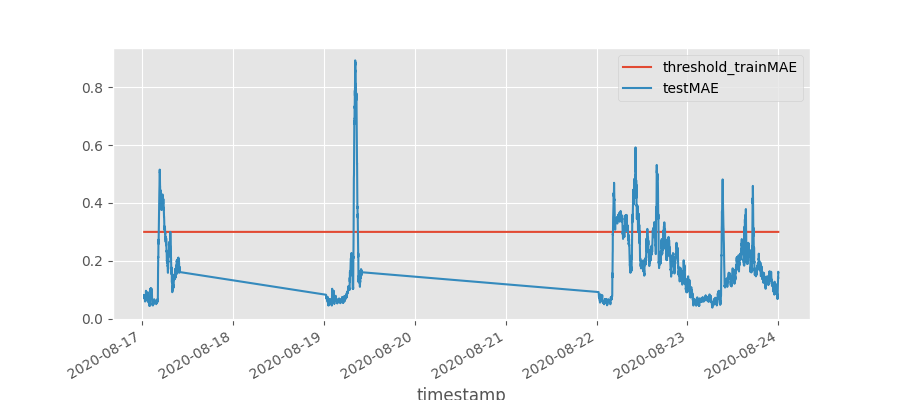

In [17]:
# Plot the test MAE
plt.figure(figsize=[9, 4])
anomaly_df['threshold_trainMAE'].plot()
anomaly_df['testMAE'].plot()
plt.legend()

In [18]:
# Detect the anomaly points inside the dataset
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

<IPython.core.display.Javascript object>


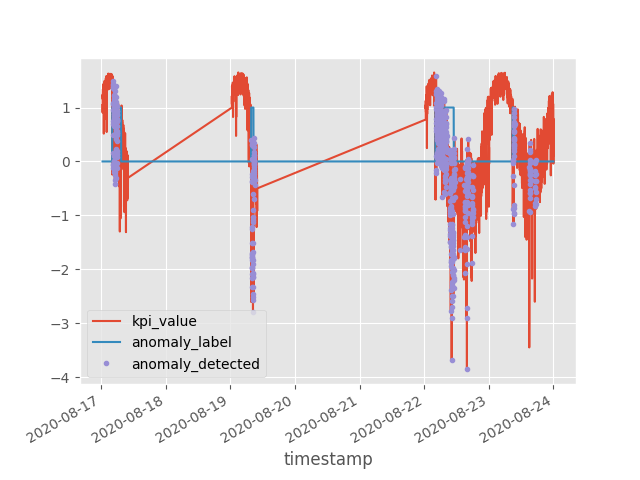

In [19]:
#Plot the anomalies
plt.figure()
anomaly_df['kpi_value'].plot()
anomaly_df['anomaly_label'].plot()
anomalies['kpi_value'].plot(marker='.', linestyle='None', label='anomaly_detected')
plt.legend()

In [20]:
# Inspect the resulting dataset
anomaly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3984 entries, 2020-08-17 00:33:00+02:00 to 2020-08-24 00:00:00+02:00
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   kpi_value           3984 non-null   float64
 1   request_count       3984 non-null   float64
 2   anomaly_label       3984 non-null   int64  
 3   testMAE             3984 non-null   float64
 4   threshold_trainMAE  3984 non-null   float64
 5   anomaly             3984 non-null   bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 190.6 KB


In [21]:
anomaly_df

,kpi_value,request_count,anomaly_label,testMAE,threshold_trainMAE,anomaly
timestamp,,,,,,
2020-08-17 00:33:00+02:00,1.046498,1.249119,0,0.082070,0.3,False
2020-08-17 00:34:00+02:00,0.907252,1.161120,0,0.070435,0.3,False
2020-08-17 00:35:00+02:00,1.017913,1.226050,0,0.076051,0.3,False
2020-08-17 00:36:00+02:00,1.241087,1.310383,0,0.080609,0.3,False
2020-08-17 00:37:00+02:00,1.232323,1.260119,0,0.075784,0.3,False
...,...,...,...,...,...,...
2020-08-23 23:56:00+02:00,0.106058,1.186481,0,0.143559,0.3,False
2020-08-23 23:57:00+02:00,0.795930,1.293424,0,0.139946,0.3,False
2020-08-23 23:58:00+02:00,0.695386,1.230480,0,0.138318,0.3,False


In [22]:
# Compute the precision in the test dataset
precision_score(anomaly_df['anomaly_label'], anomaly_df['anomaly'])

0.7186544342507645

In [23]:
# Compute the recall in the test dataset
recall_score(anomaly_df['anomaly_label'], anomaly_df['anomaly'])

0.6811594202898551

In [24]:
# Compute the F1 score in the test dataset
f1_score(anomaly_df['anomaly_label'], anomaly_df['anomaly'])

0.699404761904762